## Odds ratio with bootstrap confidence intervals

**Raibatak Das - 2023-Jun-01**

This notebook contains Julia code to create contingency tables, compute odds ratios and estimate their confidence intervals using bootstrap resampling.

In [2]:
using TypedTables, StatsBase, Plots, LaTeXStrings

### Example 1: Aspirin, heart attacks and strokes

The following data report the results of a randomized controlled trial that followed 22071 physicians who were assigned to receive either a 325 mg dose of aspirin or a placebo every other day. The number of heart attacks and strokes recorded during the 60 month study period are shown in the contingency table below:

Treatment | Heart attacks | Strokes | Total
--------- | ------------- | ------- | -----   
Placebo   | 239           | 98      | 11034
Aspirin   | 139           | 119     | 11037

The next code block creates a contingency table with this information

In [3]:
t = Table(Treatment    = ["Placebo", "Aspirin"],
          n            = [11034, 11037],
          HeartAttacks = [239, 139], 
          Strokes      = [98, 119])

Table with 4 columns and 2 rows:
     Treatment  n      HeartAttacks  Strokes
   ┌────────────────────────────────────────
 1 │ Placebo    11034  239           98
 2 │ Aspirin    11037  139           119

Define function to compute odds and odds ratio from contingency table

In [4]:
function Odds(ctable::Table, outcome::Symbol, 
              totals::Symbol = :n, 
              groups::Symbol = :Treatment)
    """Compute odds and odds ratios for outcome of interest
    from input contingency table."""
    e = getproperty(ctable, outcome)
    n = getproperty(ctable, totals)
    odds = e ./ (n - e)
    g = getproperties(ctable, (groups,))
    results = Table(g, 
                    Odds      = odds,
                    OddsRatio = odds/odds[1])
    return results
end

Odds (generic function with 3 methods)

Compute odds ratio for heart attacks and strokes under each treatment

In [6]:
oddsHA = Odds(t, :HeartAttacks)

Table with 3 columns and 2 rows:
     Treatment  Odds       OddsRatio
   ┌────────────────────────────────
 1 │ Placebo    0.0221399  1.0
 2 │ Aspirin    0.0127546  0.576093

In [7]:
oddsST = Odds(t, :Strokes)

Table with 3 columns and 2 rows:
     Treatment  Odds        OddsRatio
   ┌─────────────────────────────────
 1 │ Placebo    0.00896123  1.0
 2 │ Aspirin    0.0108994   1.21629

Define a function to simulate a bootstrap sample of the odds ratio 

In [12]:
function BootOdds(e::Int, n::Int, nboot::Int = 2000)
    """Generate bootstrap sample of the odds of an event
    that is observed e times in a sample of size n using
    nboot resamples"""
    # Generate vector of observations from input data
    obs = vcat(trues(e), falses(n - e))
    # Simulate bootstrap replicates
    odds = zeros(nboot)
    for j = 1:nboot 
        b = sample(obs, n) # Resample with replacement
        if length(b) != n
            print(length(b))
        end
        # Compute odds for bootstrap sample
        s = sum(b)
        odds[j] = s/(n - s)
    end
    return odds
end

BootOdds (generic function with 2 methods)

Compute bootstrap distributions of the odds of getting a heart attack for each treatment, and estimate 95% confidence interval

In [13]:
# Heart attacks for placebo group
e, n = t[1][(:HeartAttacks, :n)]
ha_pla = BootOdds(239, 11034)
pct = [2.5, 97.5]
percentile(ha_pla, pct)

2-element Vector{Float64}:
 0.019401330376940133
 0.02508361204013378

In [14]:
# Heart attacks for aspirin group
e, n = t[2][(:HeartAttacks, :n)]
ha_asp = BootOdds(e, n)
percentile(ha_asp, pct)

2-element Vector{Float64}:
 0.010621737936086438
 0.014992217866547962

Compute odds ratio and plot histogram

In [15]:
# Compute odds ratio
oddsratio_ha = ha_asp ./ ha_pla
percentile(oddsratio_ha, [2.5, 97.5])

2-element Vector{Float64}:
 0.4659690962772292
 0.7040380374862183

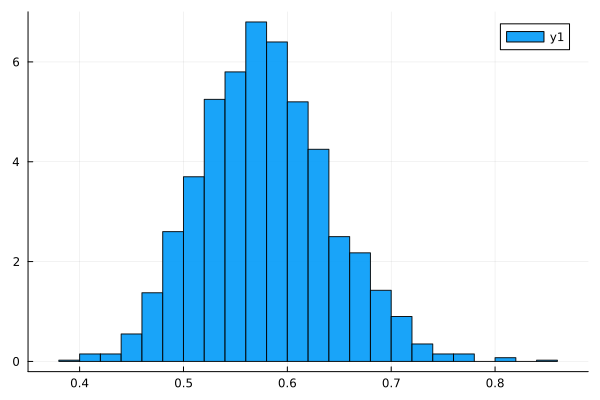

In [16]:
histogram(oddsratio_ha, normalize = true, alpha = 0.9)

Define a wrapper function to compute odds ratio and generate bootstrap confidence intervals

In [17]:
function OddsRatio(ctable::Table, outcome::Symbol, totals::Symbol = :n, groups::Symbol = :Treatment,
                   pctl::Float64 = 95.0; nboot::Int = 2000)
    """Compute odds ratio for outcome of interest
    from input contingency table and compute
    percentile confidence interval of odds ratio
    by simulating nboot bootstap replicates. 
    Optionally return the bootstrap distribution"""
    # Compute odds and odds ratio
    oddsTable = Odds(ctable, outcome, totals, groups)
    # Simulate bootstrap distributions for each treatment
    bootDistr = zeros((nboot, 2))
    for row = 1:2
        e, n = [getproperty(ctable[row], p) 
                for p = (outcome, totals)]
        bootDistr[:,row] = BootOdds(e, n, nboot)
    end
    bootOR = bootDistr[:,2] ./ bootDistr[:,1]
    # Compute percentile confidence interval from bootstrap samples
    if (pctl <= 0) | (pctl >= 100)
        pctl = 95.0
    end
    lo = (100 - pctl)/2
    hi = 100 - lo
    CI = percentile(bootOR, [lo, hi])
    bootCI = (Percentile = pctl, CI = CI)
    # Gather results
    return (OddsRatio = oddsTable, 
            CI        = bootCI, 
            Distr     = bootOR)
end

OddsRatio (generic function with 4 methods)

Odds ratio analysis for both outcomes

In [35]:
# Compute odd ratio and CI for heart attacks
haOR = OddsRatio(t, :HeartAttacks)
haOR.OddsRatio

Table with 3 columns and 2 rows:
     Treatment  Odds       OddsRatio
   ┌────────────────────────────────
 1 │ Placebo    0.0221399  1.0
 2 │ Aspirin    0.0127546  0.576093

In [36]:
haOR.CI

(Percentile = 95.0, CI = [0.4655044616962059, 0.7100297278163149])

Analysis of stroke data

In [37]:
stOR = OddsRatio(t, :Strokes)
stOR.OddsRatio

Table with 3 columns and 2 rows:
     Treatment  Odds        OddsRatio
   ┌─────────────────────────────────
 1 │ Placebo    0.00896123  1.0
 2 │ Aspirin    0.0108994   1.21629

In [38]:
stOR.CI

(Percentile = 95.0, CI = [0.9156188391388423, 1.611707058667726])

Plot histograms of bootstrap distributions

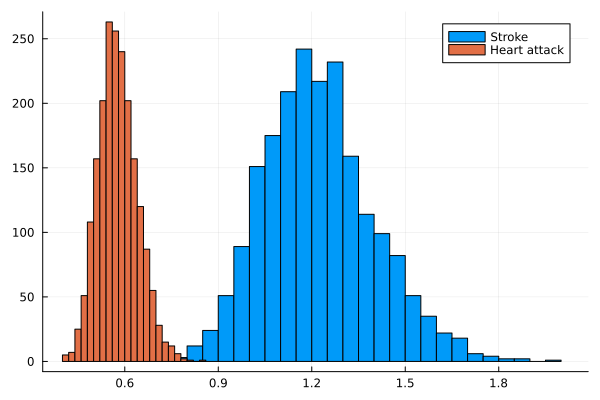

In [42]:
histogram(stOR.Distr, bins = 30, normalize = false, label = "Stroke")
histogram!(haOR.Distr, bins = 30, normalize = false, label = "Heart attack")

## Example 2: Smoking and lung cancer

Case control study to determine if there is a correlation between smoking and lung cancer. 

In [8]:
t = Table(Group        = ["Control", "LungCancer"],
          n            = [649, 649],
          Smokers      = [622, 647],
          NonSmokers   = [ 27,   2])

Table with 4 columns and 2 rows:
     Group       n    Smokers  NonSmokers
   ┌─────────────────────────────────────
 1 │ Control     649  622      27
 2 │ LungCancer  649  647      2

In [52]:
smoking = OddsRatio(t, :NonSmokers, :n, :Group)
smoking.OddsRatio

Table with 3 columns and 2 rows:
     Group       Odds        OddsRatio
   ┌──────────────────────────────────
 1 │ Control     0.0434084   1.0
 2 │ LungCancer  0.00309119  0.0712119

In [53]:
smoking.CI

(Percentile = 95.0, CI = [0.0, 0.2173987941429802])

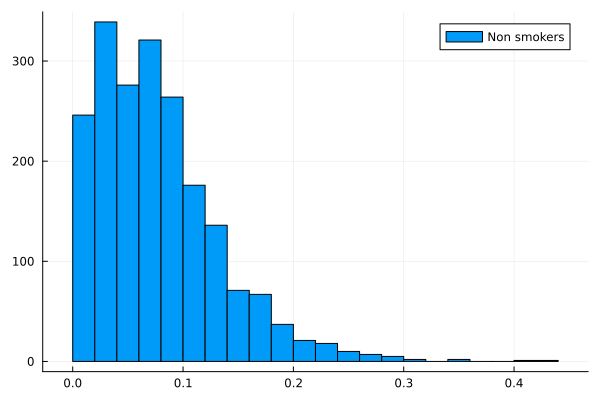

In [65]:
histogram(smoking.Distr, bins = 35, label = "Non smokers")